## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)

    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [2]:
reactomeVersion = 81
species = 68323
# species = 

endpointURL = "http://localhost:3030/REACTOME_DRERIO/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,106483
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,44777
2,http://www.biopax.org/release/biopax-level3.owl#Protein,23939
3,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,22224
4,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,21727
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,20904
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,20904
7,http://www.biopax.org/release/biopax-level3.owl#Evidence,9017
8,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,8990
9,http://www.biopax.org/release/biopax-level3.owl#Complex,8618


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,467


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,8151


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3631


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4520


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,388


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,240


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3391


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,2865


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    8618.000000
mean        2.339638
std         3.040077
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        65.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

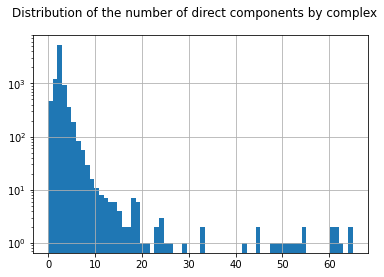

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

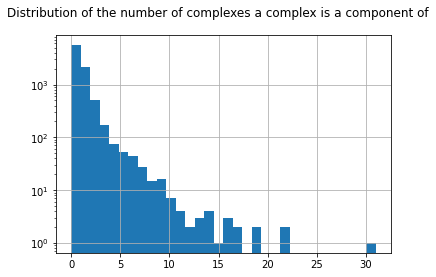

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,11986


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,5208


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,4192


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,6374


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,6824


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 ?loc1# ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2,loc1


How many cliques? <a class="anchor" id="cliques"></a>

In [22]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

IndexError: index 0 is out of bounds for axis 0 with size 0

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes


![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [23]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w',encoding="utf-8") as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat))#.decode('UTF-8'))
        i += 1
    
     #${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v81-Complex*.ttl > reactome-v81-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [24]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))

Function 3: delete all complexes  <a class="anchor" id="function3"></a>

In [25]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [26]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [27]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.17462825775146484	http://www.reactome.org/biopax/81/68323#Complex1
1	0.2822415828704834	http://www.reactome.org/biopax/81/68323#Complex3
2	0.35562753677368164	http://www.reactome.org/biopax/81/68323#Complex5
3	0.47831058502197266	http://www.reactome.org/biopax/81/68323#Complex14
4	1.1108601093292236	http://www.reactome.org/biopax/81/68323#Complex18
5	1.7221434116363525	http://www.reactome.org/biopax/81/68323#Complex24
6	2.2384836673736572	http://www.reactome.org/biopax/81/68323#Complex25
7	2.3932738304138184	http://www.reactome.org/biopax/81/68323#Complex28
8	3.0166614055633545	http://www.reactome.org/biopax/81/68323#Complex31
9	3.510113477706909	http://www.reactome.org/biopax/81/68323#Complex37
10	4.038797855377197	http://www.reactome.org/biopax/81/68323#Complex46
11	4.1470725536346436	http://www.reactome.org/biopax/81/68323#Complex106
12	4.6689558029174805	http://www.reactome.org/biopax/81/68323#Complex107
13	4.79302191734314	http://www.reactome.org/biopax/81/68323#Complex110
14	

114	25.245603561401367	http://www.reactome.org/biopax/81/68323#Complex451
115	25.53848910331726	http://www.reactome.org/biopax/81/68323#Complex452
116	25.940316200256348	http://www.reactome.org/biopax/81/68323#Complex453
117	26.379115343093872	http://www.reactome.org/biopax/81/68323#Complex454
118	26.832333087921143	http://www.reactome.org/biopax/81/68323#Complex455
119	27.208539724349976	http://www.reactome.org/biopax/81/68323#Complex457
120	27.73559546470642	http://www.reactome.org/biopax/81/68323#Complex458
121	28.156591415405273	http://www.reactome.org/biopax/81/68323#Complex459
122	28.53726840019226	http://www.reactome.org/biopax/81/68323#Complex460
123	28.97235870361328	http://www.reactome.org/biopax/81/68323#Complex461
124	29.41817307472229	http://www.reactome.org/biopax/81/68323#Complex462
125	29.805631160736084	http://www.reactome.org/biopax/81/68323#Complex463
126	30.216569423675537	http://www.reactome.org/biopax/81/68323#Complex466
127	30.763796091079712	http://www.reactome.

227	82.36240935325623	http://www.reactome.org/biopax/81/68323#Complex621
228	83.52814507484436	http://www.reactome.org/biopax/81/68323#Complex622
229	84.507807970047	http://www.reactome.org/biopax/81/68323#Complex624
230	84.65779137611389	http://www.reactome.org/biopax/81/68323#Complex625
231	85.74405694007874	http://www.reactome.org/biopax/81/68323#Complex626
232	86.71380138397217	http://www.reactome.org/biopax/81/68323#Complex629
233	88.2750563621521	http://www.reactome.org/biopax/81/68323#Complex630
234	89.89266204833984	http://www.reactome.org/biopax/81/68323#Complex631
235	91.46359038352966	http://www.reactome.org/biopax/81/68323#Complex632
236	93.21273589134216	http://www.reactome.org/biopax/81/68323#Complex633
237	95.48181557655334	http://www.reactome.org/biopax/81/68323#Complex634
238	96.08074927330017	http://www.reactome.org/biopax/81/68323#Complex635
239	96.61083698272705	http://www.reactome.org/biopax/81/68323#Complex636
240	96.8285813331604	http://www.reactome.org/biopax/81

339	197.70838975906372	http://www.reactome.org/biopax/81/68323#Complex772
340	198.2447485923767	http://www.reactome.org/biopax/81/68323#Complex775
341	199.04655766487122	http://www.reactome.org/biopax/81/68323#Complex776
342	199.1973922252655	http://www.reactome.org/biopax/81/68323#Complex779
343	200.5646893978119	http://www.reactome.org/biopax/81/68323#Complex781
344	201.26135087013245	http://www.reactome.org/biopax/81/68323#Complex783
345	202.1957287788391	http://www.reactome.org/biopax/81/68323#Complex789
346	202.40018272399902	http://www.reactome.org/biopax/81/68323#Complex790
347	202.61316752433777	http://www.reactome.org/biopax/81/68323#Complex798
348	202.75679802894592	http://www.reactome.org/biopax/81/68323#Complex800
349	202.89295935630798	http://www.reactome.org/biopax/81/68323#Complex801
350	203.03759598731995	http://www.reactome.org/biopax/81/68323#Complex887
351	203.15059399604797	http://www.reactome.org/biopax/81/68323#Complex894
352	203.41411471366882	http://www.reactome

451	217.01324367523193	http://www.reactome.org/biopax/81/68323#Complex1151
452	217.2360053062439	http://www.reactome.org/biopax/81/68323#Complex1152
453	217.41026520729065	http://www.reactome.org/biopax/81/68323#Complex1154
454	217.7570607662201	http://www.reactome.org/biopax/81/68323#Complex1157
455	217.85739850997925	http://www.reactome.org/biopax/81/68323#Complex1165
456	217.93947172164917	http://www.reactome.org/biopax/81/68323#Complex1168
457	218.03946447372437	http://www.reactome.org/biopax/81/68323#Complex1169
458	218.1127405166626	http://www.reactome.org/biopax/81/68323#Complex1171
459	218.19182801246643	http://www.reactome.org/biopax/81/68323#Complex1173
460	218.35985612869263	http://www.reactome.org/biopax/81/68323#Complex1174
461	218.43281173706055	http://www.reactome.org/biopax/81/68323#Complex1180
462	218.5698697566986	http://www.reactome.org/biopax/81/68323#Complex1182
463	218.8540461063385	http://www.reactome.org/biopax/81/68323#Complex1183
464	219.08939290046692	http://

561	239.358225107193	http://www.reactome.org/biopax/81/68323#Complex1470
562	239.85976672172546	http://www.reactome.org/biopax/81/68323#Complex1471
563	239.98274874687195	http://www.reactome.org/biopax/81/68323#Complex1476
564	240.20003366470337	http://www.reactome.org/biopax/81/68323#Complex1474
565	240.25519371032715	http://www.reactome.org/biopax/81/68323#Complex1477
566	240.411052942276	http://www.reactome.org/biopax/81/68323#Complex1479
567	240.68928599357605	http://www.reactome.org/biopax/81/68323#Complex1480
568	241.01668119430542	http://www.reactome.org/biopax/81/68323#Complex1481
569	241.2241735458374	http://www.reactome.org/biopax/81/68323#Complex1484
570	241.62027406692505	http://www.reactome.org/biopax/81/68323#Complex1492
571	242.0603449344635	http://www.reactome.org/biopax/81/68323#Complex1485
572	242.207777261734	http://www.reactome.org/biopax/81/68323#Complex1488
573	242.4119577407837	http://www.reactome.org/biopax/81/68323#Complex1486
574	242.53595519065857	http://www.

671	263.08904123306274	http://www.reactome.org/biopax/81/68323#Complex1682
672	263.3778839111328	http://www.reactome.org/biopax/81/68323#Complex1684
673	263.5219073295593	http://www.reactome.org/biopax/81/68323#Complex1685
674	263.635507106781	http://www.reactome.org/biopax/81/68323#Complex1688
675	263.9314248561859	http://www.reactome.org/biopax/81/68323#Complex1689
676	264.3552815914154	http://www.reactome.org/biopax/81/68323#Complex1690
677	264.7916827201843	http://www.reactome.org/biopax/81/68323#Complex1691
678	264.8983814716339	http://www.reactome.org/biopax/81/68323#Complex1693
679	265.02651286125183	http://www.reactome.org/biopax/81/68323#Complex1695
680	265.27432322502136	http://www.reactome.org/biopax/81/68323#Complex1696
681	265.4214961528778	http://www.reactome.org/biopax/81/68323#Complex1698
682	265.6415812969208	http://www.reactome.org/biopax/81/68323#Complex1700
683	265.9059793949127	http://www.reactome.org/biopax/81/68323#Complex1699
684	266.1077661514282	http://www.rea

782	285.51452374458313	http://www.reactome.org/biopax/81/68323#Complex1880
783	285.70552682876587	http://www.reactome.org/biopax/81/68323#Complex1881
784	285.8550908565521	http://www.reactome.org/biopax/81/68323#Complex1883
785	286.0380742549896	http://www.reactome.org/biopax/81/68323#Complex1884
786	286.17490434646606	http://www.reactome.org/biopax/81/68323#Complex1886
787	286.4070580005646	http://www.reactome.org/biopax/81/68323#Complex1887
788	286.59954047203064	http://www.reactome.org/biopax/81/68323#Complex1888
789	286.7385399341583	http://www.reactome.org/biopax/81/68323#Complex1890
790	287.01962184906006	http://www.reactome.org/biopax/81/68323#Complex1891
791	287.3215169906616	http://www.reactome.org/biopax/81/68323#Complex1892
792	287.61954498291016	http://www.reactome.org/biopax/81/68323#Complex1896
793	287.7638556957245	http://www.reactome.org/biopax/81/68323#Complex1897
794	287.95187044143677	http://www.reactome.org/biopax/81/68323#Complex1900
795	288.1278955936432	http://ww

893	307.70527815818787	http://www.reactome.org/biopax/81/68323#Complex2102
894	307.82592129707336	http://www.reactome.org/biopax/81/68323#Complex2107
895	307.9505469799042	http://www.reactome.org/biopax/81/68323#Complex2109
896	308.1414783000946	http://www.reactome.org/biopax/81/68323#Complex2110
897	308.25232434272766	http://www.reactome.org/biopax/81/68323#Complex2112
898	308.46983671188354	http://www.reactome.org/biopax/81/68323#Complex2113
899	308.6864194869995	http://www.reactome.org/biopax/81/68323#Complex2118
900	308.8260591030121	http://www.reactome.org/biopax/81/68323#Complex2119
901	309.05803894996643	http://www.reactome.org/biopax/81/68323#Complex2121
902	309.2705738544464	http://www.reactome.org/biopax/81/68323#Complex2124
903	309.5346133708954	http://www.reactome.org/biopax/81/68323#Complex2125
904	309.67231011390686	http://www.reactome.org/biopax/81/68323#Complex2128
905	309.99245047569275	http://www.reactome.org/biopax/81/68323#Complex2129
906	310.2981927394867	http://ww

1003	332.4985685348511	http://www.reactome.org/biopax/81/68323#Complex2306
1004	332.79324865341187	http://www.reactome.org/biopax/81/68323#Complex2297
1005	332.883207321167	http://www.reactome.org/biopax/81/68323#Complex2300
1006	332.9778709411621	http://www.reactome.org/biopax/81/68323#Complex2307
1007	333.0786781311035	http://www.reactome.org/biopax/81/68323#Complex2309
1008	333.30859541893005	http://www.reactome.org/biopax/81/68323#Complex2312
1009	333.46029686927795	http://www.reactome.org/biopax/81/68323#Complex2316
1010	333.5578269958496	http://www.reactome.org/biopax/81/68323#Complex2319
1011	333.75314688682556	http://www.reactome.org/biopax/81/68323#Complex2322
1012	334.01324915885925	http://www.reactome.org/biopax/81/68323#Complex2320
1013	334.1084740161896	http://www.reactome.org/biopax/81/68323#Complex2323
1014	334.3755271434784	http://www.reactome.org/biopax/81/68323#Complex2326
1015	334.702424287796	http://www.reactome.org/biopax/81/68323#Complex2324
1016	334.8896288871765

1112	354.35009360313416	http://www.reactome.org/biopax/81/68323#Complex2919
1113	354.75357389450073	http://www.reactome.org/biopax/81/68323#Complex2920
1114	355.27168798446655	http://www.reactome.org/biopax/81/68323#Complex2921
1115	356.52776646614075	http://www.reactome.org/biopax/81/68323#Complex2923
1116	358.73119497299194	http://www.reactome.org/biopax/81/68323#Complex2924
1117	361.44711446762085	http://www.reactome.org/biopax/81/68323#Complex2928
1118	361.83804392814636	http://www.reactome.org/biopax/81/68323#Complex2929
1119	365.6086699962616	http://www.reactome.org/biopax/81/68323#Complex2930
1120	369.6239016056061	http://www.reactome.org/biopax/81/68323#Complex2931
1121	370.1266508102417	http://www.reactome.org/biopax/81/68323#Complex2933
1122	376.2267110347748	http://www.reactome.org/biopax/81/68323#Complex2934
1123	380.73507261276245	http://www.reactome.org/biopax/81/68323#Complex2935
1124	381.15778970718384	http://www.reactome.org/biopax/81/68323#Complex2936
1125	384.1057803

1221	594.0388996601105	http://www.reactome.org/biopax/81/68323#Complex3463
1222	595.0721483230591	http://www.reactome.org/biopax/81/68323#Complex3464
1223	596.722174167633	http://www.reactome.org/biopax/81/68323#Complex3466
1224	597.462372303009	http://www.reactome.org/biopax/81/68323#Complex3467
1225	598.061808347702	http://www.reactome.org/biopax/81/68323#Complex3468
1226	598.6514546871185	http://www.reactome.org/biopax/81/68323#Complex3470
1227	606.0302720069885	http://www.reactome.org/biopax/81/68323#Complex3471
1228	607.3526103496552	http://www.reactome.org/biopax/81/68323#Complex3472
1229	611.8838837146759	http://www.reactome.org/biopax/81/68323#Complex3476
1230	618.1473164558411	http://www.reactome.org/biopax/81/68323#Complex3473
1231	618.5510439872742	http://www.reactome.org/biopax/81/68323#Complex3474
1232	618.7524259090424	http://www.reactome.org/biopax/81/68323#Complex3477
1233	619.5522754192352	http://www.reactome.org/biopax/81/68323#Complex3479
1234	623.6696021556854	http:

1331	766.1412689685822	http://www.reactome.org/biopax/81/68323#Complex3719
1332	766.2294869422913	http://www.reactome.org/biopax/81/68323#Complex3720
1333	775.3845162391663	http://www.reactome.org/biopax/81/68323#Complex3730
1334	784.3583827018738	http://www.reactome.org/biopax/81/68323#Complex3722
1335	784.9368135929108	http://www.reactome.org/biopax/81/68323#Complex3725
1336	785.2729406356812	http://www.reactome.org/biopax/81/68323#Complex3731
1337	795.0173511505127	http://www.reactome.org/biopax/81/68323#Complex3734
1338	796.0673086643219	http://www.reactome.org/biopax/81/68323#Complex3738
1339	796.3703129291534	http://www.reactome.org/biopax/81/68323#Complex3740
1340	796.5343101024628	http://www.reactome.org/biopax/81/68323#Complex3741
1341	796.6957535743713	http://www.reactome.org/biopax/81/68323#Complex3743
1342	796.8114335536957	http://www.reactome.org/biopax/81/68323#Complex3744
1343	796.9934966564178	http://www.reactome.org/biopax/81/68323#Complex3745
1344	797.1005828380585	ht

1441	915.1234648227692	http://www.reactome.org/biopax/81/68323#Complex3968
1442	925.4029655456543	http://www.reactome.org/biopax/81/68323#Complex3969
1443	935.2071657180786	http://www.reactome.org/biopax/81/68323#Complex3970
1444	944.9237959384918	http://www.reactome.org/biopax/81/68323#Complex3972
1445	954.1825966835022	http://www.reactome.org/biopax/81/68323#Complex3977
1446	960.7123975753784	http://www.reactome.org/biopax/81/68323#Complex3979
1447	969.4190011024475	http://www.reactome.org/biopax/81/68323#Complex3980
1448	970.105188369751	http://www.reactome.org/biopax/81/68323#Complex3981
1449	970.8702688217163	http://www.reactome.org/biopax/81/68323#Complex3982
1450	971.6231951713562	http://www.reactome.org/biopax/81/68323#Complex3985
1451	981.3417608737946	http://www.reactome.org/biopax/81/68323#Complex3987
1452	981.6134347915649	http://www.reactome.org/biopax/81/68323#Complex3989
1453	990.1484174728394	http://www.reactome.org/biopax/81/68323#Complex3992
1454	990.2680714130402	htt

1550	1034.8200788497925	http://www.reactome.org/biopax/81/68323#Complex4166
1551	1034.9984862804413	http://www.reactome.org/biopax/81/68323#Complex4167
1552	1035.1762199401855	http://www.reactome.org/biopax/81/68323#Complex4169
1553	1035.6095371246338	http://www.reactome.org/biopax/81/68323#Complex4170
1554	1036.1189095973969	http://www.reactome.org/biopax/81/68323#Complex4171
1555	1036.623467206955	http://www.reactome.org/biopax/81/68323#Complex4172
1556	1037.1767828464508	http://www.reactome.org/biopax/81/68323#Complex4173
1557	1037.3025460243225	http://www.reactome.org/biopax/81/68323#Complex4174
1558	1037.8131663799286	http://www.reactome.org/biopax/81/68323#Complex4175
1559	1037.9523839950562	http://www.reactome.org/biopax/81/68323#Complex4176
1560	1038.4536476135254	http://www.reactome.org/biopax/81/68323#Complex4177
1561	1038.582069158554	http://www.reactome.org/biopax/81/68323#Complex4178
1562	1039.059518814087	http://www.reactome.org/biopax/81/68323#Complex4179
1563	1039.55875

1660	1192.3620474338531	http://www.reactome.org/biopax/81/68323#Complex4425
1661	1192.4997854232788	http://www.reactome.org/biopax/81/68323#Complex4434
1662	1192.7405257225037	http://www.reactome.org/biopax/81/68323#Complex4442
1663	1192.8478727340698	http://www.reactome.org/biopax/81/68323#Complex4446
1664	1192.9551584720612	http://www.reactome.org/biopax/81/68323#Complex4448
1665	1193.1540040969849	http://www.reactome.org/biopax/81/68323#Complex4450
1666	1193.4498360157013	http://www.reactome.org/biopax/81/68323#Complex4453
1667	1193.9251201152802	http://www.reactome.org/biopax/81/68323#Complex4454
1668	1194.1540033817291	http://www.reactome.org/biopax/81/68323#Complex4468
1669	1194.941302061081	http://www.reactome.org/biopax/81/68323#Complex4457
1670	1195.036102771759	http://www.reactome.org/biopax/81/68323#Complex4463
1671	1195.146139383316	http://www.reactome.org/biopax/81/68323#Complex4469
1672	1195.9100053310394	http://www.reactome.org/biopax/81/68323#Complex4473
1673	1196.90006

1769	1232.173481464386	http://www.reactome.org/biopax/81/68323#Complex4802
1770	1232.4867289066315	http://www.reactome.org/biopax/81/68323#Complex4804
1771	1232.7419555187225	http://www.reactome.org/biopax/81/68323#Complex4805
1772	1233.0185186862946	http://www.reactome.org/biopax/81/68323#Complex4806
1773	1233.3301000595093	http://www.reactome.org/biopax/81/68323#Complex4808
1774	1233.702219247818	http://www.reactome.org/biopax/81/68323#Complex4810
1775	1234.0770745277405	http://www.reactome.org/biopax/81/68323#Complex4812
1776	1237.745950460434	http://www.reactome.org/biopax/81/68323#Complex4813
1777	1237.9086906909943	http://www.reactome.org/biopax/81/68323#Complex4815
1778	1238.0692632198334	http://www.reactome.org/biopax/81/68323#Complex4816
1779	1238.2634935379028	http://www.reactome.org/biopax/81/68323#Complex4817
1780	1238.397028207779	http://www.reactome.org/biopax/81/68323#Complex4819
1781	1238.5546553134918	http://www.reactome.org/biopax/81/68323#Complex4820
1782	1238.884716

1879	1253.4740269184113	http://www.reactome.org/biopax/81/68323#Complex5151
1880	1253.5633568763733	http://www.reactome.org/biopax/81/68323#Complex5152
1881	1253.7565052509308	http://www.reactome.org/biopax/81/68323#Complex5153
1882	1253.9541611671448	http://www.reactome.org/biopax/81/68323#Complex5155
1883	1254.1178159713745	http://www.reactome.org/biopax/81/68323#Complex5157
1884	1254.3111324310303	http://www.reactome.org/biopax/81/68323#Complex5158
1885	1254.4125981330872	http://www.reactome.org/biopax/81/68323#Complex5159
1886	1254.5339732170105	http://www.reactome.org/biopax/81/68323#Complex5162
1887	1254.7165219783783	http://www.reactome.org/biopax/81/68323#Complex5163
1888	1254.8753864765167	http://www.reactome.org/biopax/81/68323#Complex5164
1889	1255.1259880065918	http://www.reactome.org/biopax/81/68323#Complex5166
1890	1255.3643662929535	http://www.reactome.org/biopax/81/68323#Complex5167
1891	1255.6031591892242	http://www.reactome.org/biopax/81/68323#Complex5168
1892	1255.81

1988	1346.0541269779205	http://www.reactome.org/biopax/81/68323#Complex5373
1989	1346.2178978919983	http://www.reactome.org/biopax/81/68323#Complex5374
1990	1346.3472471237183	http://www.reactome.org/biopax/81/68323#Complex5375
1991	1346.4686570167542	http://www.reactome.org/biopax/81/68323#Complex5377
1992	1346.5891962051392	http://www.reactome.org/biopax/81/68323#Complex5379
1993	1346.7516074180603	http://www.reactome.org/biopax/81/68323#Complex5380
1994	1347.0726766586304	http://www.reactome.org/biopax/81/68323#Complex5381
1995	1347.4587678909302	http://www.reactome.org/biopax/81/68323#Complex5382
1996	1347.8558673858643	http://www.reactome.org/biopax/81/68323#Complex5383
1997	1347.974838733673	http://www.reactome.org/biopax/81/68323#Complex5389
1998	1348.0589790344238	http://www.reactome.org/biopax/81/68323#Complex5396
1999	1348.2216229438782	http://www.reactome.org/biopax/81/68323#Complex5397
2000	1348.305226802826	http://www.reactome.org/biopax/81/68323#Complex5398
2001	1348.4308

2097	1368.0726363658905	http://www.reactome.org/biopax/81/68323#Complex5601
2098	1368.3692882061005	http://www.reactome.org/biopax/81/68323#Complex5604
2099	1368.5391836166382	http://www.reactome.org/biopax/81/68323#Complex5605
2100	1368.686499118805	http://www.reactome.org/biopax/81/68323#Complex5606
2101	1368.9033620357513	http://www.reactome.org/biopax/81/68323#Complex5610
2102	1369.06165599823	http://www.reactome.org/biopax/81/68323#Complex5611
2103	1369.2096309661865	http://www.reactome.org/biopax/81/68323#Complex5613
2104	1369.3684649467468	http://www.reactome.org/biopax/81/68323#Complex5614
2105	1369.774974346161	http://www.reactome.org/biopax/81/68323#Complex5616
2106	1370.2690415382385	http://www.reactome.org/biopax/81/68323#Complex5617
2107	1370.575432062149	http://www.reactome.org/biopax/81/68323#Complex5618
2108	1370.9702641963959	http://www.reactome.org/biopax/81/68323#Complex5620
2109	1371.0508620738983	http://www.reactome.org/biopax/81/68323#Complex5621
2110	1371.4451014

2207	1416.1518576145172	http://www.reactome.org/biopax/81/68323#Complex5892
2208	1416.2620882987976	http://www.reactome.org/biopax/81/68323#Complex5894
2209	1416.339795589447	http://www.reactome.org/biopax/81/68323#Complex5896
2210	1416.4194548130035	http://www.reactome.org/biopax/81/68323#Complex5898
2211	1416.5154621601105	http://www.reactome.org/biopax/81/68323#Complex5901
2212	1416.620062828064	http://www.reactome.org/biopax/81/68323#Complex5907
2213	1416.7011740207672	http://www.reactome.org/biopax/81/68323#Complex5908
2214	1416.7820284366608	http://www.reactome.org/biopax/81/68323#Complex5910
2215	1416.8729767799377	http://www.reactome.org/biopax/81/68323#Complex5913
2216	1417.000205039978	http://www.reactome.org/biopax/81/68323#Complex5911
2217	1417.048169374466	http://www.reactome.org/biopax/81/68323#Complex5932
2218	1417.2098524570465	http://www.reactome.org/biopax/81/68323#Complex5935
2219	1417.3709630966187	http://www.reactome.org/biopax/81/68323#Complex5939
2220	1417.790914

2317	1456.0388288497925	http://www.reactome.org/biopax/81/68323#Complex6177
2318	1459.3046216964722	http://www.reactome.org/biopax/81/68323#Complex6178
2319	1462.133101940155	http://www.reactome.org/biopax/81/68323#Complex6179
2320	1463.4120800495148	http://www.reactome.org/biopax/81/68323#Complex6180
2321	1464.0060439109802	http://www.reactome.org/biopax/81/68323#Complex6187
2322	1464.1749930381775	http://www.reactome.org/biopax/81/68323#Complex6191
2323	1464.3360662460327	http://www.reactome.org/biopax/81/68323#Complex6192
2324	1464.420501947403	http://www.reactome.org/biopax/81/68323#Complex6198
2325	1464.5719742774963	http://www.reactome.org/biopax/81/68323#Complex6202
2326	1464.661902666092	http://www.reactome.org/biopax/81/68323#Complex6203
2327	1464.8102052211761	http://www.reactome.org/biopax/81/68323#Complex6204
2328	1464.9599905014038	http://www.reactome.org/biopax/81/68323#Complex6213
2329	1465.0725905895233	http://www.reactome.org/biopax/81/68323#Complex6214
2330	1465.17899

2426	1516.495462179184	http://www.reactome.org/biopax/81/68323#Complex6392
2427	1517.5891041755676	http://www.reactome.org/biopax/81/68323#Complex6393
2428	1518.3925187587738	http://www.reactome.org/biopax/81/68323#Complex6394
2429	1520.872088432312	http://www.reactome.org/biopax/81/68323#Complex6395
2430	1525.1885356903076	http://www.reactome.org/biopax/81/68323#Complex6396
2431	1526.4901196956635	http://www.reactome.org/biopax/81/68323#Complex6397
2432	1529.791024684906	http://www.reactome.org/biopax/81/68323#Complex6398
2433	1533.4093589782715	http://www.reactome.org/biopax/81/68323#Complex6399
2434	1536.8009932041168	http://www.reactome.org/biopax/81/68323#Complex6400
2435	1538.232204914093	http://www.reactome.org/biopax/81/68323#Complex6401
2436	1539.6780366897583	http://www.reactome.org/biopax/81/68323#Complex6402
2437	1541.0811026096344	http://www.reactome.org/biopax/81/68323#Complex6403
2438	1545.5841975212097	http://www.reactome.org/biopax/81/68323#Complex6404
2439	1547.474888

2536	1614.109342098236	http://www.reactome.org/biopax/81/68323#Complex6620
2537	1614.2088830471039	http://www.reactome.org/biopax/81/68323#Complex6621
2538	1614.3785452842712	http://www.reactome.org/biopax/81/68323#Complex6622
2539	1614.5828139781952	http://www.reactome.org/biopax/81/68323#Complex6623
2540	1614.6758608818054	http://www.reactome.org/biopax/81/68323#Complex6624
2541	1614.875538110733	http://www.reactome.org/biopax/81/68323#Complex6625
2542	1615.1131863594055	http://www.reactome.org/biopax/81/68323#Complex6628
2543	1615.2726047039032	http://www.reactome.org/biopax/81/68323#Complex6629
2544	1615.4882428646088	http://www.reactome.org/biopax/81/68323#Complex6630
2545	1615.5831446647644	http://www.reactome.org/biopax/81/68323#Complex6632
2546	1615.678828716278	http://www.reactome.org/biopax/81/68323#Complex6633
2547	1615.7732841968536	http://www.reactome.org/biopax/81/68323#Complex6634
2548	1615.870727777481	http://www.reactome.org/biopax/81/68323#Complex6635
2549	1615.964038

2645	1631.2418591976166	http://www.reactome.org/biopax/81/68323#Complex6869
2646	1631.4017007350922	http://www.reactome.org/biopax/81/68323#Complex6870
2647	1631.5082519054413	http://www.reactome.org/biopax/81/68323#Complex6871
2648	1631.6139206886292	http://www.reactome.org/biopax/81/68323#Complex6879
2649	1631.693880558014	http://www.reactome.org/biopax/81/68323#Complex6882
2650	1631.7628264427185	http://www.reactome.org/biopax/81/68323#Complex6885
2651	1631.8308923244476	http://www.reactome.org/biopax/81/68323#Complex6888
2652	1631.89954829216	http://www.reactome.org/biopax/81/68323#Complex6889
2653	1631.9699425697327	http://www.reactome.org/biopax/81/68323#Complex6890
2654	1632.0528757572174	http://www.reactome.org/biopax/81/68323#Complex6892
2655	1632.1967673301697	http://www.reactome.org/biopax/81/68323#Complex6893
2656	1632.3286335468292	http://www.reactome.org/biopax/81/68323#Complex6895
2657	1632.5098252296448	http://www.reactome.org/biopax/81/68323#Complex6898
2658	1632.63753

2754	1646.6419234275818	http://www.reactome.org/biopax/81/68323#Complex7074
2755	1646.72105550766	http://www.reactome.org/biopax/81/68323#Complex7075
2756	1646.7957599163055	http://www.reactome.org/biopax/81/68323#Complex7077
2757	1646.9228827953339	http://www.reactome.org/biopax/81/68323#Complex7083
2758	1647.0169880390167	http://www.reactome.org/biopax/81/68323#Complex7084
2759	1647.147788286209	http://www.reactome.org/biopax/81/68323#Complex7086
2760	1647.2628874778748	http://www.reactome.org/biopax/81/68323#Complex7087
2761	1647.3756935596466	http://www.reactome.org/biopax/81/68323#Complex7089
2762	1647.506451845169	http://www.reactome.org/biopax/81/68323#Complex7090
2763	1647.6376600265503	http://www.reactome.org/biopax/81/68323#Complex7091
2764	1647.7640063762665	http://www.reactome.org/biopax/81/68323#Complex7092
2765	1647.902113199234	http://www.reactome.org/biopax/81/68323#Complex7093
2766	1648.0363998413086	http://www.reactome.org/biopax/81/68323#Complex7094
2767	1648.1793527

2863	1663.4726178646088	http://www.reactome.org/biopax/81/68323#Complex7442
2864	1663.6129794120789	http://www.reactome.org/biopax/81/68323#Complex7446
2865	1663.8158330917358	http://www.reactome.org/biopax/81/68323#Complex7447
2866	1664.037615776062	http://www.reactome.org/biopax/81/68323#Complex7448
2867	1664.2909362316132	http://www.reactome.org/biopax/81/68323#Complex7451
2868	1664.5216636657715	http://www.reactome.org/biopax/81/68323#Complex7449
2869	1664.6676952838898	http://www.reactome.org/biopax/81/68323#Complex7452
2870	1664.8093497753143	http://www.reactome.org/biopax/81/68323#Complex7454
2871	1664.910932302475	http://www.reactome.org/biopax/81/68323#Complex7455
2872	1665.0243473052979	http://www.reactome.org/biopax/81/68323#Complex7456
2873	1665.1400198936462	http://www.reactome.org/biopax/81/68323#Complex7459
2874	1665.2829892635345	http://www.reactome.org/biopax/81/68323#Complex7461
2875	1665.4987235069275	http://www.reactome.org/biopax/81/68323#Complex7462
2876	1665.6669

2972	1683.0402619838715	http://www.reactome.org/biopax/81/68323#Complex7677
2973	1683.2643113136292	http://www.reactome.org/biopax/81/68323#Complex7683
2974	1683.4220769405365	http://www.reactome.org/biopax/81/68323#Complex7686
2975	1683.620586156845	http://www.reactome.org/biopax/81/68323#Complex7687
2976	1683.8487541675568	http://www.reactome.org/biopax/81/68323#Complex7699
2977	1683.973931312561	http://www.reactome.org/biopax/81/68323#Complex7705
2978	1684.0836308002472	http://www.reactome.org/biopax/81/68323#Complex7706
2979	1684.1905269622803	http://www.reactome.org/biopax/81/68323#Complex7708
2980	1684.2965822219849	http://www.reactome.org/biopax/81/68323#Complex7716
2981	1684.4213283061981	http://www.reactome.org/biopax/81/68323#Complex7717
2982	1684.5443861484528	http://www.reactome.org/biopax/81/68323#Complex7718
2983	1684.6374025344849	http://www.reactome.org/biopax/81/68323#Complex7719
2984	1684.7300157546997	http://www.reactome.org/biopax/81/68323#Complex7731
2985	1684.8270

3082	1705.360629081726	http://www.reactome.org/biopax/81/68323#Complex7894
3083	1705.5651376247406	http://www.reactome.org/biopax/81/68323#Complex7895
3084	1705.7760035991669	http://www.reactome.org/biopax/81/68323#Complex7901
3085	1705.9425573349	http://www.reactome.org/biopax/81/68323#Complex7902
3086	1706.1071059703827	http://www.reactome.org/biopax/81/68323#Complex7905
3087	1706.2304873466492	http://www.reactome.org/biopax/81/68323#Complex7906
3088	1706.3345575332642	http://www.reactome.org/biopax/81/68323#Complex7914
3089	1706.4378907680511	http://www.reactome.org/biopax/81/68323#Complex7934
3090	1706.5349259376526	http://www.reactome.org/biopax/81/68323#Complex7936
3091	1706.7939794063568	http://www.reactome.org/biopax/81/68323#Complex7937
3092	1706.9319229125977	http://www.reactome.org/biopax/81/68323#Complex7938
3093	1707.0290293693542	http://www.reactome.org/biopax/81/68323#Complex7943
3094	1707.0994985103607	http://www.reactome.org/biopax/81/68323#Complex7944
3095	1707.255955

3191	1737.1818058490753	http://www.reactome.org/biopax/81/68323#Complex8142
3192	1737.5920102596283	http://www.reactome.org/biopax/81/68323#Complex8143
3193	1737.7852189540863	http://www.reactome.org/biopax/81/68323#Complex8145
3194	1737.982277393341	http://www.reactome.org/biopax/81/68323#Complex8146
3195	1738.181710243225	http://www.reactome.org/biopax/81/68323#Complex8152
3196	1738.2816367149353	http://www.reactome.org/biopax/81/68323#Complex8155
3197	1738.385259628296	http://www.reactome.org/biopax/81/68323#Complex8158
3198	1738.4840483665466	http://www.reactome.org/biopax/81/68323#Complex8161
3199	1738.5864174365997	http://www.reactome.org/biopax/81/68323#Complex8164
3200	1738.717602968216	http://www.reactome.org/biopax/81/68323#Complex8166
3201	1738.8271071910858	http://www.reactome.org/biopax/81/68323#Complex8168
3202	1738.9399118423462	http://www.reactome.org/biopax/81/68323#Complex8176
3203	1739.0479574203491	http://www.reactome.org/biopax/81/68323#Complex8177
3204	1739.151009

3301	1761.9377381801605	http://www.reactome.org/biopax/81/68323#Complex8374
3302	1762.0851051807404	http://www.reactome.org/biopax/81/68323#Complex8376
3303	1762.1302919387817	http://www.reactome.org/biopax/81/68323#Complex8378
3304	1762.2079100608826	http://www.reactome.org/biopax/81/68323#Complex8380
3305	1762.351194858551	http://www.reactome.org/biopax/81/68323#Complex8381
3306	1762.424593448639	http://www.reactome.org/biopax/81/68323#Complex8382
3307	1762.5637619495392	http://www.reactome.org/biopax/81/68323#Complex8383
3308	1762.7527632713318	http://www.reactome.org/biopax/81/68323#Complex8446
3309	1762.9278268814087	http://www.reactome.org/biopax/81/68323#Complex8447
3310	1763.1287333965302	http://www.reactome.org/biopax/81/68323#Complex8448
3311	1763.5229034423828	http://www.reactome.org/biopax/81/68323#Complex8454
3312	1763.6628103256226	http://www.reactome.org/biopax/81/68323#Complex8455
3313	1763.8677685260773	http://www.reactome.org/biopax/81/68323#Complex8456
3314	1764.0689

In [ ]:
# concat files
# %%bash
# ${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

In [ ]:
# ..\..\Downloads\apache-jena-4.2.0\bat\riot.bat  --time --output=Turtle ./results/reactome-v81-48887-Complex*.ttl > ./results/reactome-v81-48887-complexes-invalid-fixed.ttl

In [28]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 319.5306649208069


In [29]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_DRERIO/update
Duration: 696.1161367893219


### (Merge files before identify and quantify redundant complexes after fixing)